# Exploring the NIFTY 50 index under different SMA regimes

Markets tend to be manic depressive, going from excessive optimism to excessive pessimism. The distribution of returns tend to be different based on the "regime." A simple way to demarcate these regimes is by using an SMA (Simple Moving Average) to bucket returns into binary groups. Here, we explore how returns are distributed in these buckets.

In [1]:
library(DBI)
library(plutoDbR)
library(plutoR)
library(tidyverse)
options("scipen"=999)
options(stringsAsFactors = FALSE)
source("/usr/share/pluto/config.R")
source("/usr/share/pluto/goofy/plot.common.R")
source("/usr/share/pluto/goofy/misc.common.R")

library(ggthemes)
library(quantmod)
library(PerformanceAnalytics)
library(reshape2)
library(ggrepel)
library(lubridate)

options(repr.plot.width=16, repr.plot.height=8)

#initialize
indices<-Indices()

In [2]:
indexName <- 'NIFTY 50 TR'
smaLb <- 50 #number of days
px <- indices$NseTimeSeries() %>%
    filter(NAME == indexName) %>%
    select(TIME_STAMP, CLOSE) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))

#if we break by years, make sure that they have at least 200 days
numDays <- px %>%
    group_by(Y = year(TIME_STAMP)) %>%
    summarize(N = n())

yrs <- numDays %>%
    filter(N >= 200) %>%
    pull(Y)

In [3]:
pXts <- xts(px$CLOSE, px$TIME_STAMP)
names(pXts) <- c('INDEX')
pXts$SMA <- SMA(pXts[,1], smaLb)
pXts$D_RET <- dailyReturn(pXts$INDEX)
pXts$D_RET_LAG <- stats::lag(pXts$D_RET, -1)
pXts$D_RET_PCT <- pXts$D_RET * 100

pXts <- na.omit(pXts)

In [4]:
statByYear <- data.frame(Y = 0, N_ABOVE = 0, N_BELOW = 0, AVG_ABOVE = 0.0, AVG_BELOW = 0.0, SD_ABOVE = 0.0, SD_BELOW = 0.0)

for(yr in yrs){
    yrStr <- toString(yr)
    numAbove <- as.numeric(sum(ifelse(pXts[yrStr,'INDEX'] > pXts[yrStr,'SMA'], 1, 0)))
    numBelow <- as.numeric(sum(ifelse(pXts[yrStr,'INDEX'] <= pXts[yrStr,'SMA'], 1, 0)))
    
    avgAbove <- as.numeric(mean(pXts[pXts[yrStr,'INDEX'] > pXts[yrStr,'SMA'], 'D_RET_PCT']))
    avgBelow <- as.numeric(mean(pXts[pXts[yrStr,'INDEX'] <= pXts[yrStr,'SMA'], 'D_RET_PCT']))
    
    sdAbove <- as.numeric(sd(pXts[pXts[yrStr,'INDEX'] > pXts[yrStr,'SMA'], 'D_RET_PCT']))
    sdBelow <- as.numeric(sd(pXts[pXts[yrStr,'INDEX'] <= pXts[yrStr,'SMA'], 'D_RET_PCT']))
    
    statByYear <- rbind(statByYear, c(yr, numAbove, numBelow, avgAbove, avgBelow, sdAbove, sdBelow))
}

statByYear <- statByYear[-1,]
print(statByYear)

      Y N_ABOVE N_BELOW   AVG_ABOVE    AVG_BELOW SD_ABOVE SD_BELOW
2  2000     113     137 -0.09308085  0.144475665 1.781884 2.174051
3  2001      94     154 -0.11532862  0.126626476 1.668974 2.197960
4  2002     103     148 -0.08142203  0.121403806 1.583569 2.249262
5  2003     173      81 -0.01570550  0.175604091 2.011063 1.954091
6  2004     170      84 -0.02150497  0.180508624 1.895375 2.177960
7  2005     188      63 -0.06156323  0.335796526 2.071944 1.758617
8  2006     202      48  0.03810886  0.032854986 2.061096 1.774749
9  2007     203      46  0.05129699 -0.037370168 1.948864 2.280878
10 2008      75     171  0.07179554 -0.002680050 2.457022 1.794149
11 2009     187      56  0.04465411 -0.054814571 2.053139 1.947710
12 2010     168      84 -0.01529373  0.153170422 2.092670 1.801981
13 2011      78     169  0.06276224  0.007988055 1.794064 2.109971
14 2012     178      73 -0.03693819  0.221319071 2.077513 1.805035
15 2013     151      99  0.16005759 -0.150441073 1.805919 2.27

In [12]:
subsetPxts <- pXts
print(head(subsetPxts))
print(tail(subsetPxts))

             INDEX      SMA        D_RET    D_RET_LAG  D_RET_PCT
1999-09-07 1466.19 1401.472 -0.004994741  0.011744726 -0.4994741
1999-09-08 1483.41 1406.013  0.011744726 -0.001853837  1.1744726
1999-09-09 1480.66 1410.593 -0.001853837 -0.004153553 -0.1853837
1999-09-10 1474.51 1414.741 -0.004153553 -0.014771009 -0.4153553
1999-09-14 1452.73 1417.768 -0.014771009  0.003042547 -1.4771009
1999-09-15 1457.15 1420.650  0.003042547 -0.017095014  0.3042547
              INDEX      SMA         D_RET     D_RET_LAG   D_RET_PCT
2020-03-04 15805.53 16882.62 -0.0046256120  0.0017512858 -0.46256120
2020-03-05 15833.21 16858.92  0.0017512858 -0.0248041932  0.17512858
2020-03-06 15440.48 16824.01 -0.0248041932 -0.0489570272 -2.48041932
2020-03-09 14684.56 16773.71 -0.0489570272  0.0006639627 -4.89570272
2020-03-11 14694.31 16726.06  0.0006639627 -0.0830205705  0.06639627
2020-03-12 13474.38 16653.61 -0.0830205705  0.0380670576 -8.30205705


In [6]:
rollN <- 200

stat200 <- rollapply(subsetPxts, rollN, function(X){
    numAbove <- as.numeric(sum(ifelse(X[,'INDEX'] > X[,'SMA'], 1, 0)))
    numBelow <- as.numeric(sum(ifelse(X[,'INDEX'] <= X[,'SMA'], 1, 0)))
    
    avgAbove <- as.numeric(mean(X[X[,'INDEX'] > X[,'SMA'], 'D_RET_PCT']))
    avgBelow <- as.numeric(mean(X[X[,'INDEX'] <= X[,'SMA'], 'D_RET_PCT']))
    
    sdAbove <- as.numeric(sd(X[X[,'INDEX'] > X[,'SMA'], 'D_RET_PCT']))
    sdBelow <- as.numeric(sd(X[X[,'INDEX'] <= X[,'SMA'], 'D_RET_PCT']))
    
    xts(matrix(c(numAbove, numBelow, avgAbove, avgBelow, sdAbove, sdBelow), nrow=1), as.Date(last(index(X))))
}, by.column = FALSE)

stat200 <- na.omit(stat200)
names(stat200) <- c('N_ABOVE', 'N_BELOW', 'AVG_ABOVE', 'AVG_BELOW', 'SD_ABOVE', 'SD_BELOW')

print("stat200: HEAD")
print(head(stat200))

print("stat200: TAIL")
print(tail(stat200))

[1] "stat200: HEAD"
           N_ABOVE N_BELOW AVG_ABOVE  AVG_BELOW SD_ABOVE SD_BELOW
2000-06-26     121      79 0.2337321 -0.2359482 1.797618 2.530461
2000-06-27     121      79 0.2393726 -0.2359482 1.796369 2.530461
2000-06-28     121      79 0.2389647 -0.2359482 1.796160 2.530461
2000-06-29     121      79 0.2530617 -0.2359482 1.799493 2.530461
2000-06-30     121      79 0.2449203 -0.2359482 1.804763 2.530461
2000-07-03     121      79 0.2704944 -0.2359482 1.802081 2.530461
[1] "stat200: TAIL"
           N_ABOVE N_BELOW AVG_ABOVE  AVG_BELOW  SD_ABOVE SD_BELOW
2020-03-04     123      77 0.1785368 -0.2473740 0.9029860 1.063199
2020-03-05     123      77 0.1785368 -0.2567789 0.9029860 1.056102
2020-03-06     123      77 0.1785368 -0.3063043 0.9029860 1.069892
2020-03-09     122      78 0.1497417 -0.3651428 0.8481118 1.183147
2020-03-11     121      79 0.1593027 -0.3596803 0.8450104 1.176540
2020-03-12     120      80 0.1577094 -0.4589600 0.8483709 1.468074


On average, returns above 50-day SMA is typically positive and has lower volatility than those below the SMA.

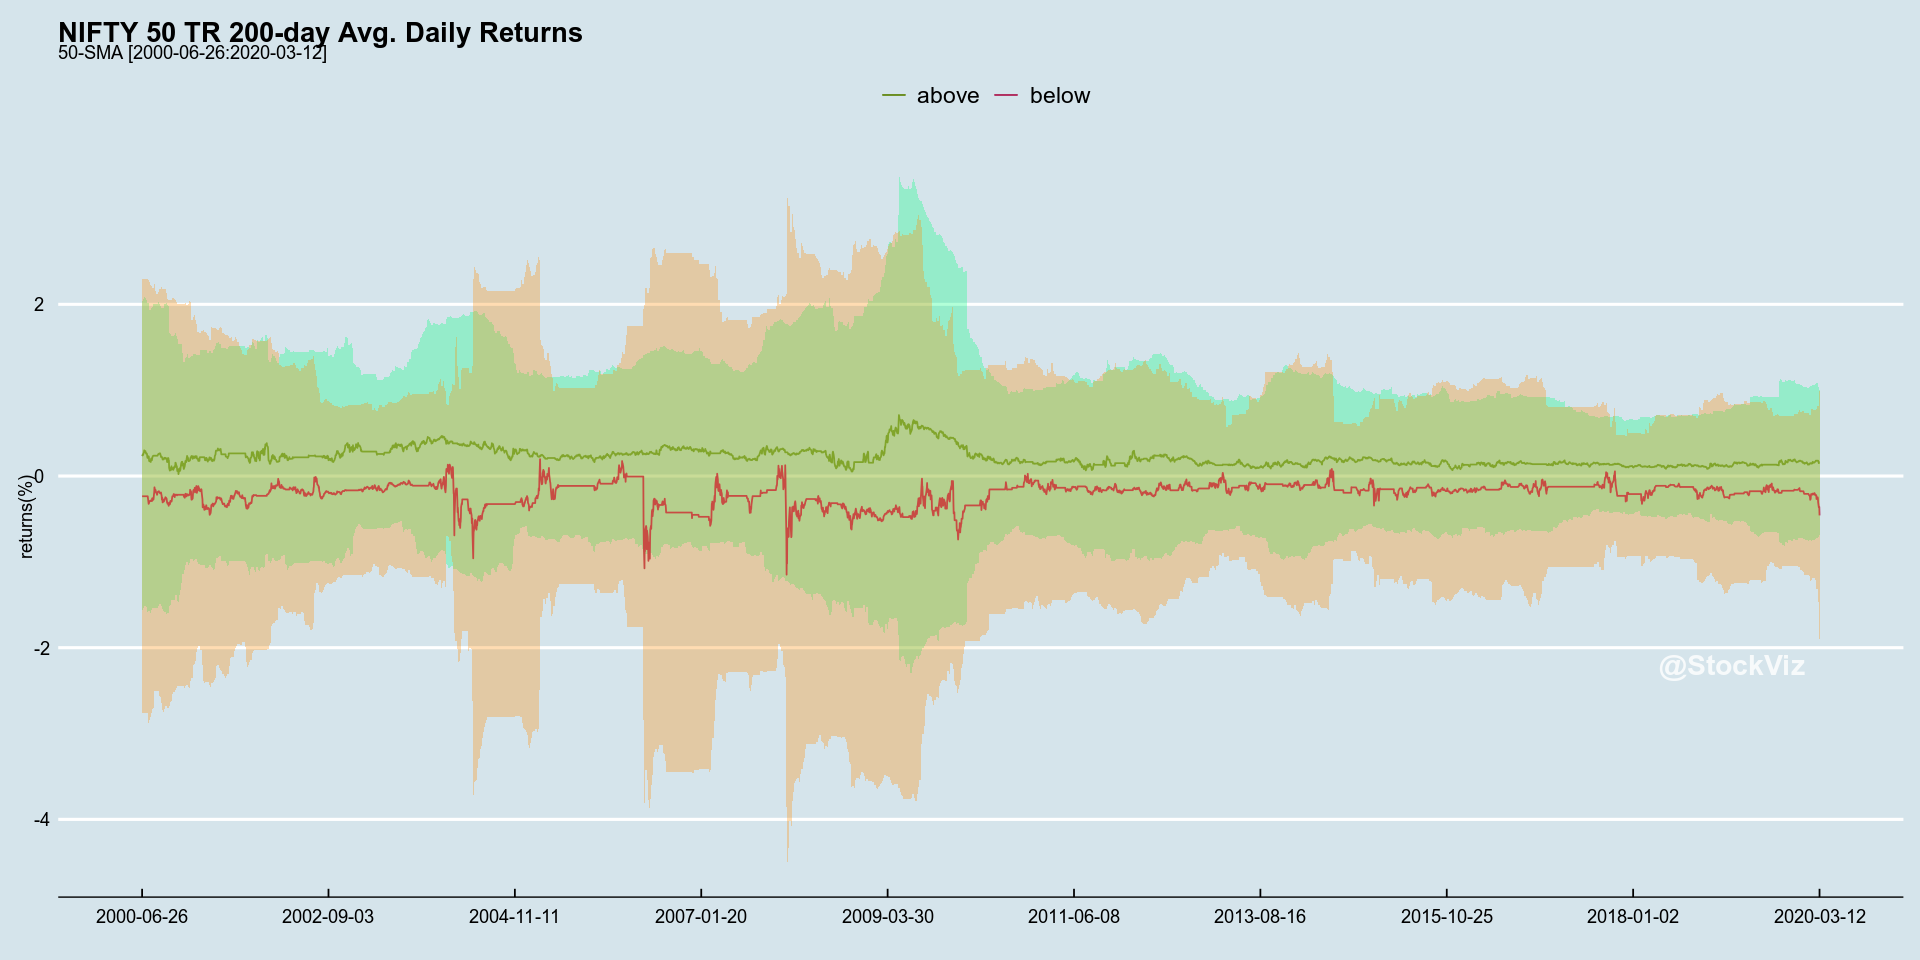

In [7]:
stat200Df <- data.frame(stat200)
stat200Df$T <- as.Date(index(stat200))

plotStart <- first(index(stat200))
plotEnd <- last(index(stat200))
xAxisTicks<-seq(plotStart, plotEnd, length.out=10)

ggplot(stat200Df, aes(x=T)) +
    theme_economist() +
    geom_line(aes(y=AVG_ABOVE, color='a')) +
    geom_ribbon(aes(ymin = AVG_ABOVE - SD_ABOVE, ymax = AVG_ABOVE + SD_ABOVE), fill='springgreen', alpha=0.3) +
    geom_line(aes(y=AVG_BELOW, color='b')) +
    geom_ribbon(aes(ymin = AVG_BELOW - SD_BELOW, ymax = AVG_BELOW + SD_BELOW), fill='darkorange', alpha=0.3) +
    scale_x_date(breaks = xAxisTicks) +
    labs(x = "", y="returns(%)", fill="", color="", 
         title = sprintf("%s %d-day Avg. Daily Returns", indexName, rollN),
         subtitle = sprintf("%d-SMA [%s:%s]", smaLb, plotStart, plotEnd)) +
    scale_colour_manual(name = '', values =c('a'='olivedrab','b'='maroon'), labels = c('above','below')) +
    annotate("text", x=plotEnd, y=min(stat200Df$AVG_ABOVE - stat200Df$SD_ABOVE), label = "@StockViz", 
             hjust=1.1, vjust=0, col="white", cex=6, fontface = "bold", alpha = 0.8)


What we see here is that on average, daily returns are negative if NIFTY is below 50-day SMA and positive otherwise. It falls within a pretty wide area so in the short-term, there many not be much to do. But if you are willing to take a longer view, there is alpha to be had.

Here's a density plot of the sample from 2010 onwards.

In [8]:
abvBlw <- merge(subsetPxts[subsetPxts[,'INDEX'] > subsetPxts[,'SMA'], 'D_RET_PCT'],
                subsetPxts[subsetPxts[,'INDEX'] <= subsetPxts[,'SMA'], 'D_RET_PCT'])

names(abvBlw) <- c('above', 'below')

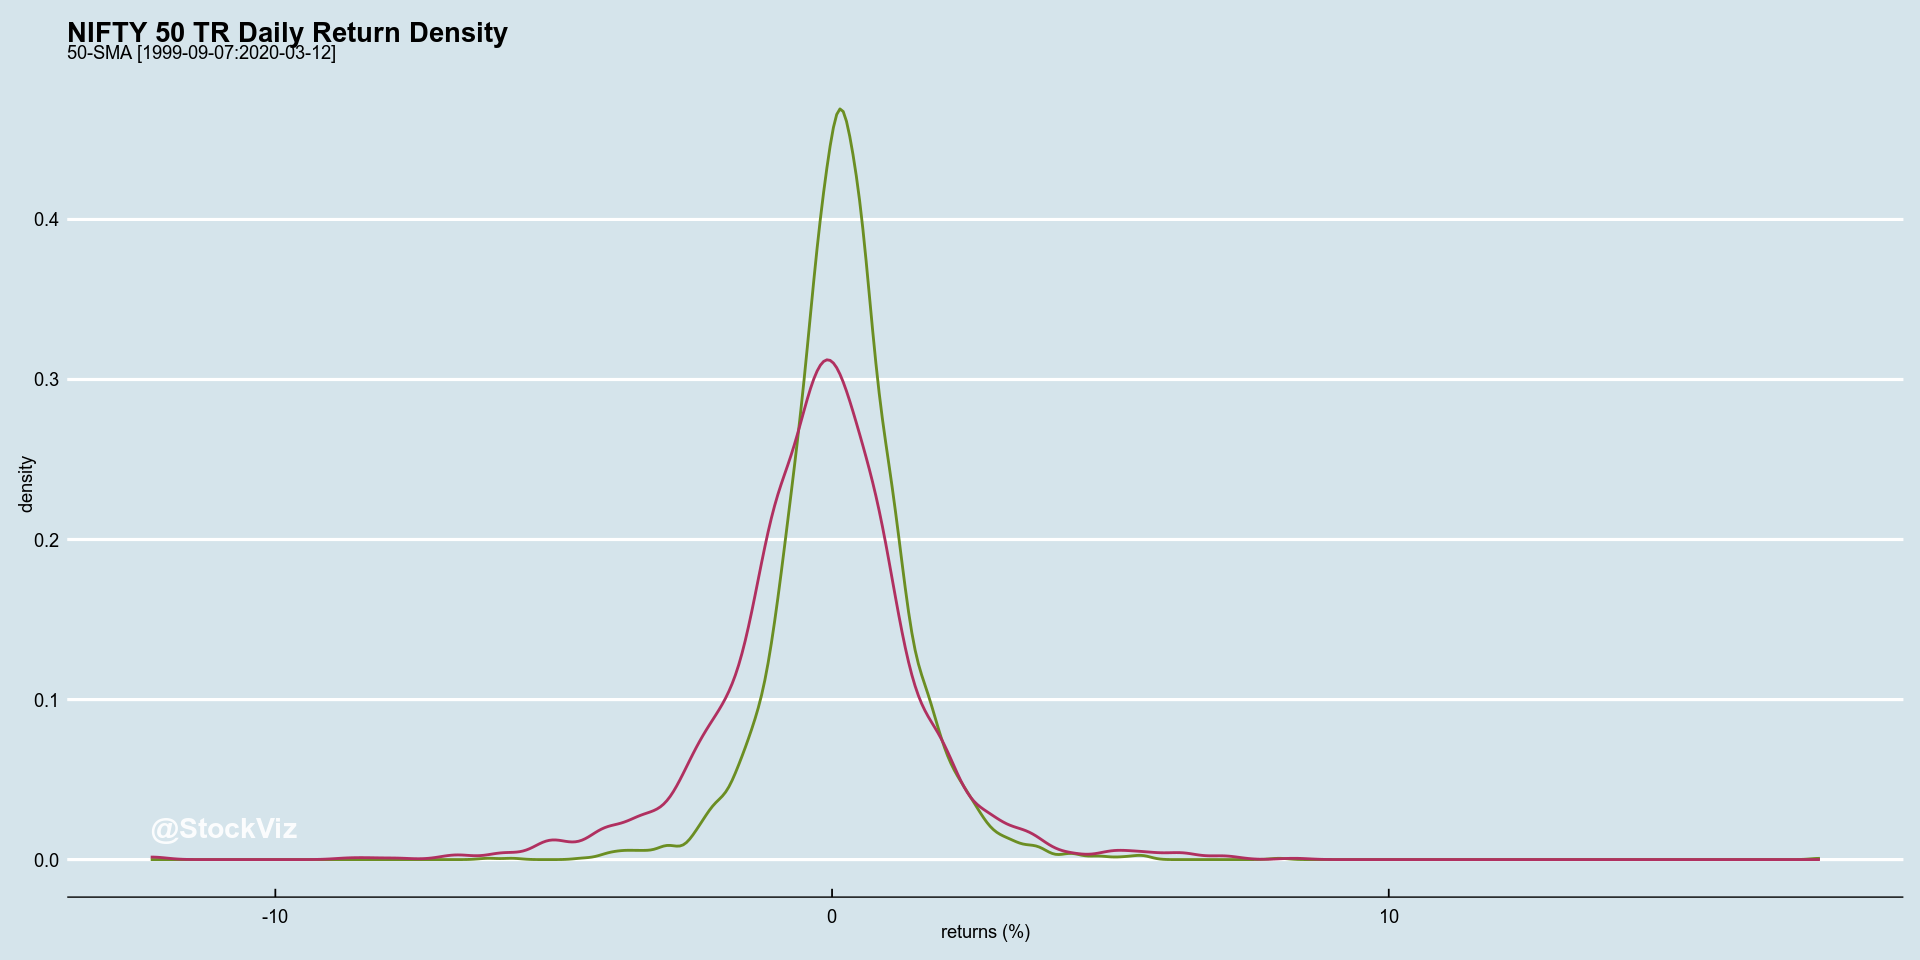

In [9]:
toPlot <- data.frame(abvBlw)
plotStart <- first(index(abvBlw))
plotEnd <- last(index(abvBlw))

ggplot(toPlot) +
    theme_economist() +
    stat_density(aes(above), geom="line", position = "identity", na.rm=T, size=0.8, color='olivedrab') +
    stat_density(aes(below), geom="line", position = "identity", na.rm=T, size=0.8, color='maroon') +
    labs(y='density', x='returns (%)', fill='', color='', 
         title = sprintf("%s Daily Return Density", indexName), 
         subtitle = sprintf("%d-SMA [%s:%s]", smaLb, plotStart, plotEnd)) +
    annotate("text", x=min(toPlot, na.rm=T), y=0, label = "@StockViz", 
             hjust=0, vjust=-1.1, col="white", cex=6, fontface = "bold", alpha = 0.9)

Note the fatter left-tails when the NIFTY is below 50-day SMA

## What if you were long only when the NIFTY traded above 50-day SMA?

In [16]:
longOnly50 <- merge(ifelse(subsetPxts[,'INDEX'] > subsetPxts[,'SMA'], subsetPxts[,'D_RET_LAG'], 0), subsetPxts[,'D_RET_LAG'])
names(longOnly50) <- c('SMA-L', 'BH')

### Cumulative returns

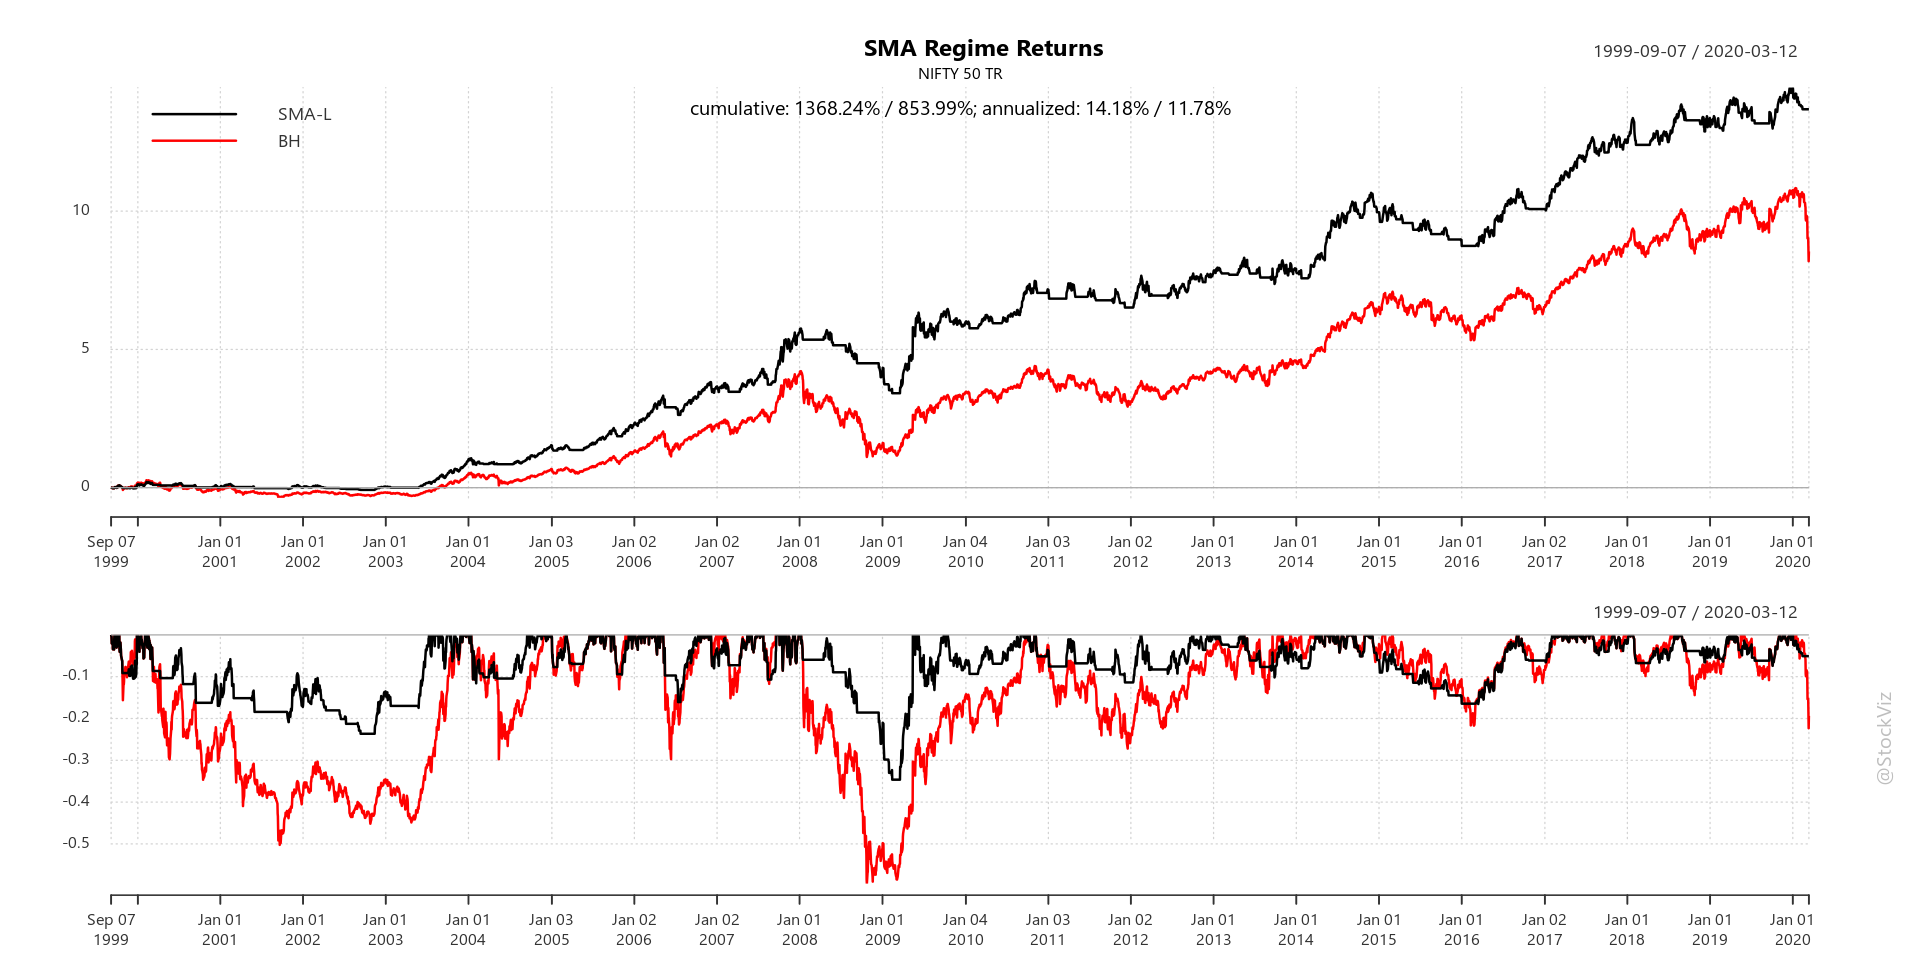

In [17]:
Common.PlotCumReturns(longOnly50, "SMA Regime Returns", indexName)

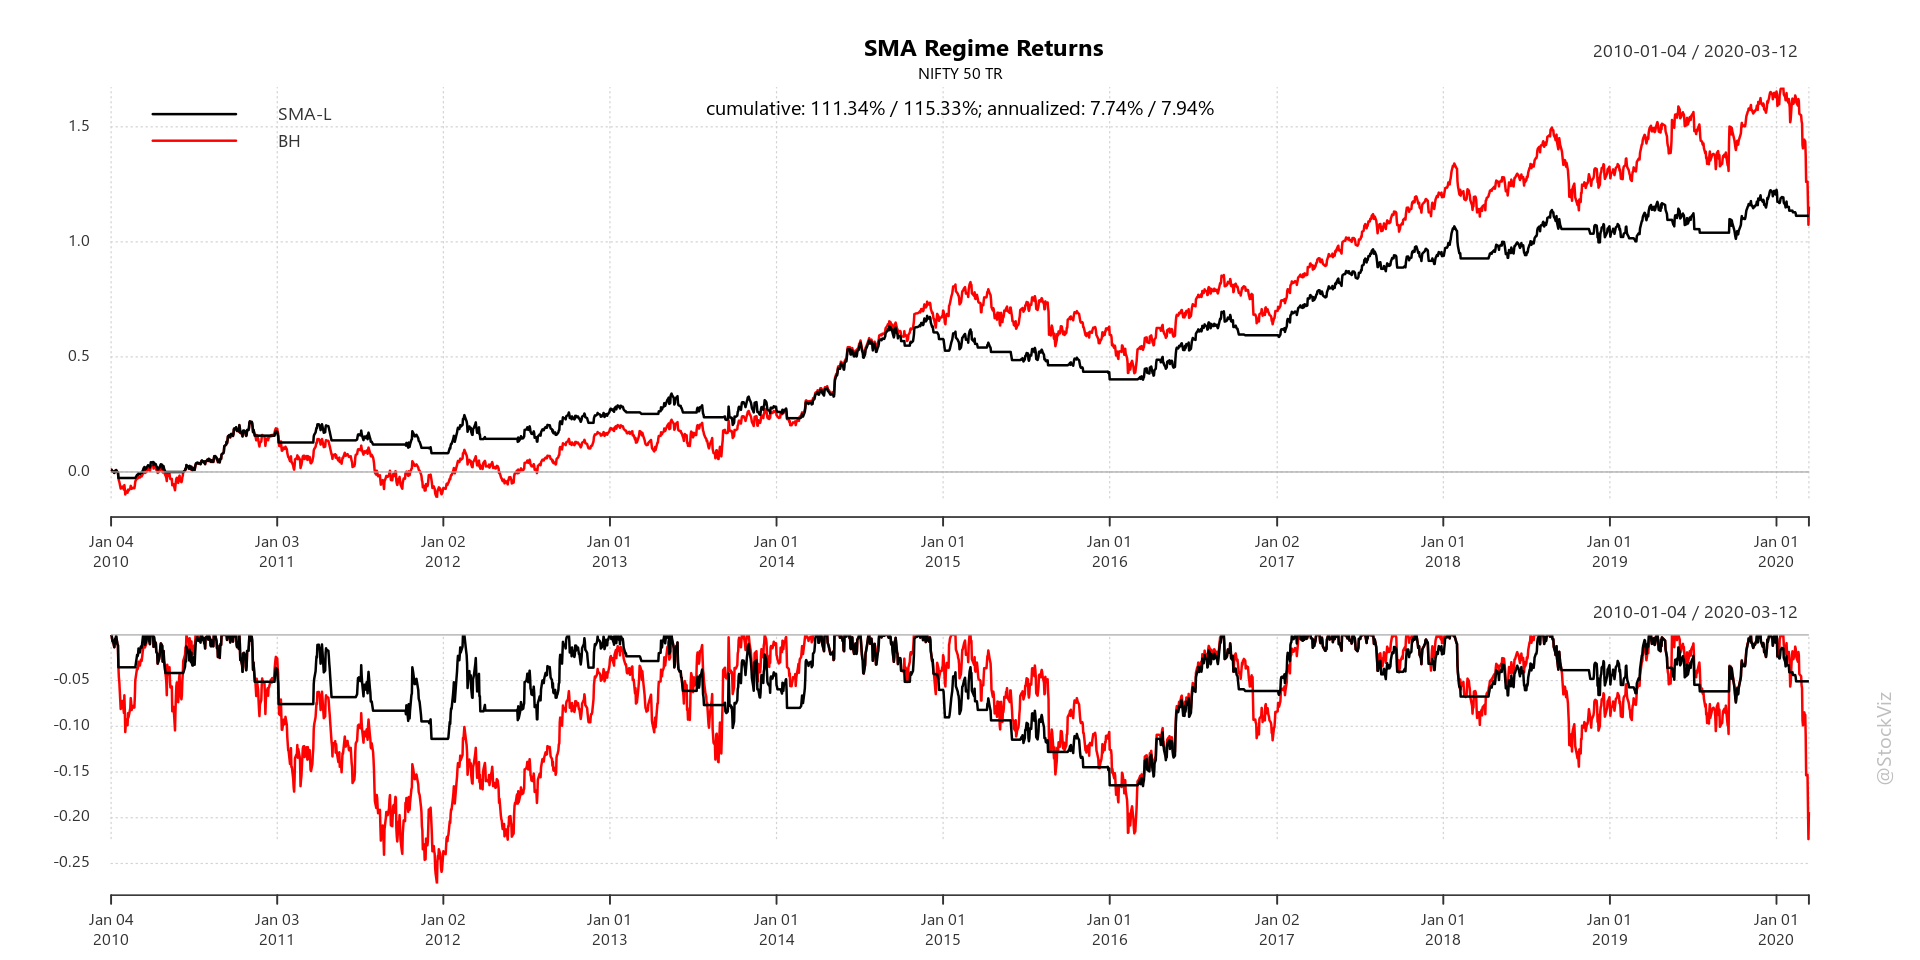

In [23]:
Common.PlotCumReturns(longOnly50["2010/",], "SMA Regime Returns", indexName)

In [21]:
returnsByYear <- data.frame(Y = 0, 'SMA-L' = 0.0, BH = 0.0)

for(yr in yrs){
    yrStr <- toString(yr)
    returnsByYear <- rbind(returnsByYear, c(yr, as.numeric(Return.cumulative(longOnly50[yrStr, 'SMA-L'])), as.numeric(Return.cumulative(longOnly50[yrStr, 'BH']))))
}

returnsByYear <- returnsByYear[-1,]
returnsByYear[,1] <- as.numeric(returnsByYear[,1])
returnsByYear[,2] <- as.numeric(returnsByYear[,2])*100.0
returnsByYear[,3] <- as.numeric(returnsByYear[,3])*100.0

### Returns by year

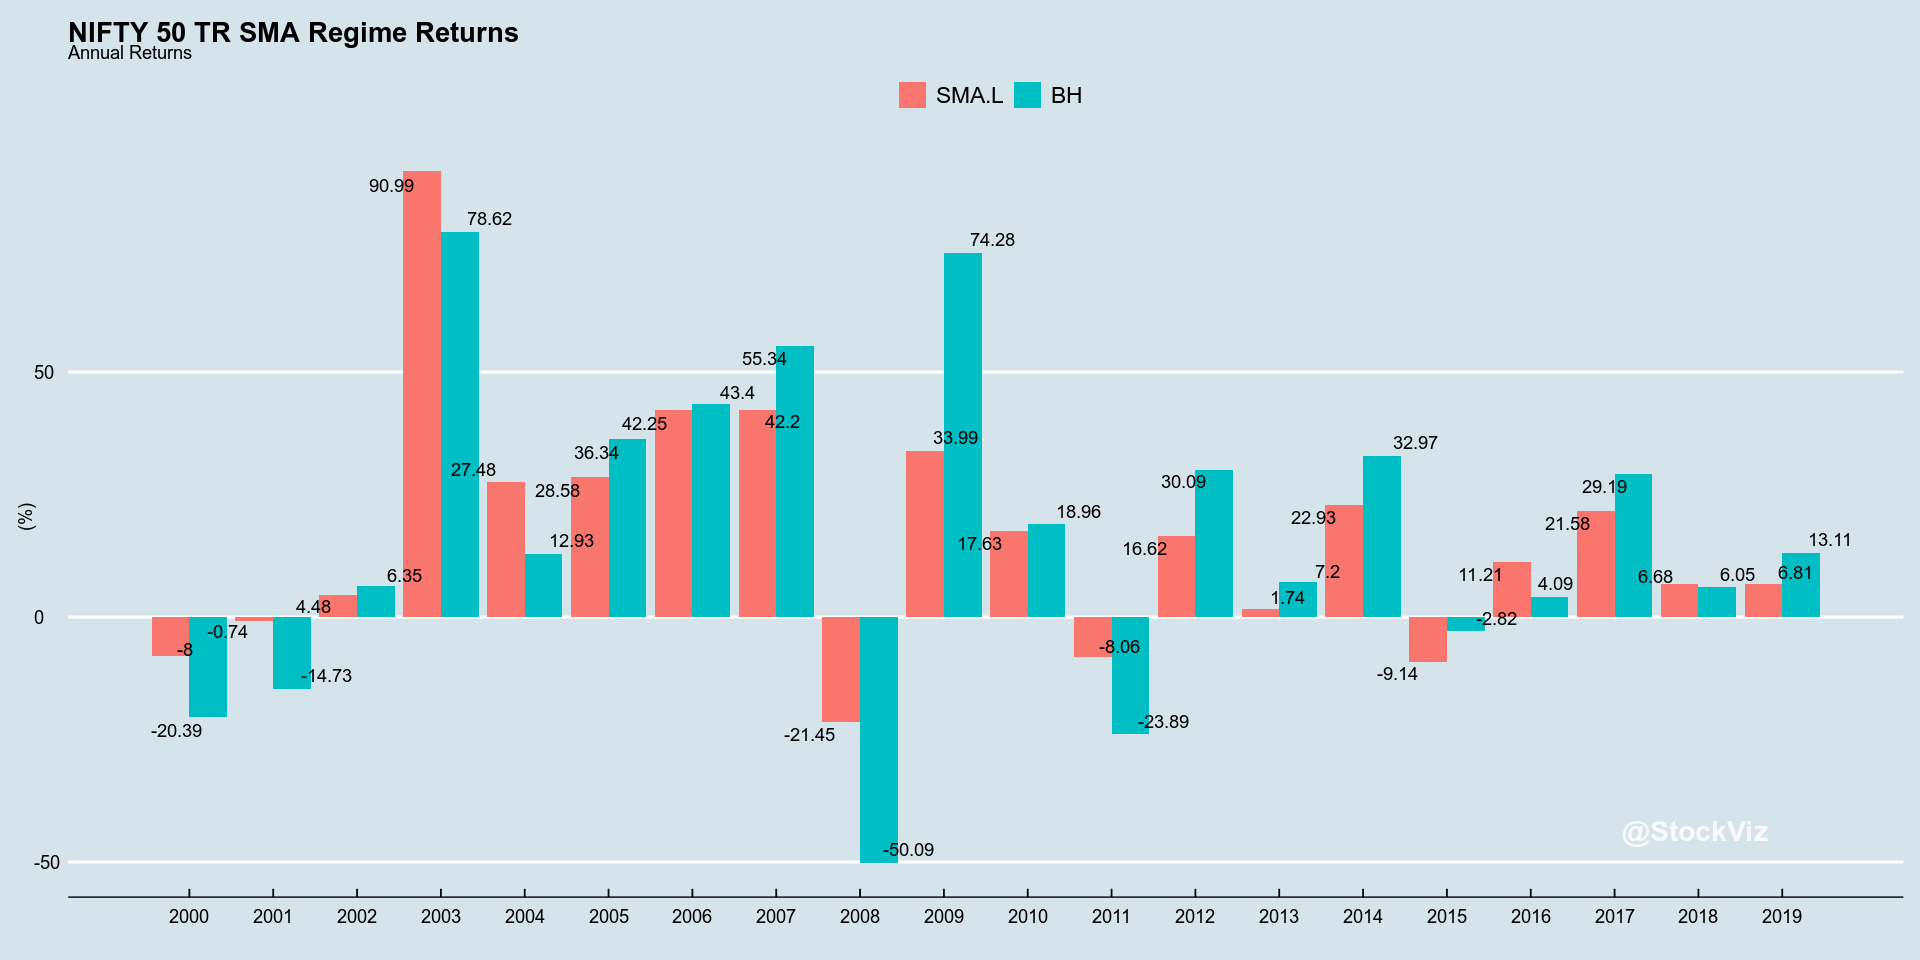

In [22]:
mDf <- melt(returnsByYear, id='Y')
ggplot(mDf, aes(x=Y, y=value, fill=variable)) +
    theme_economist() +
    geom_bar(stat="identity", position=position_dodge()) +
    scale_x_continuous(labels=returnsByYear$Y, breaks=returnsByYear$Y) +
    geom_text_repel(aes(label= round(value, 2)), position = position_dodge(0.9)) +
    labs(x='', y='(%)', fill='', title=sprintf("%s SMA Regime Returns", indexName), 
         subtitle="Annual Returns") +
    annotate("text", x=max(returnsByYear$Y), y=min(mDf$value), 
             label = "@StockViz", hjust=1.1, vjust=-1.1, 
             col="white", cex=6, fontface = "bold", alpha = 0.8)  

This notebook was created using [pluto](http://pluto.studio). Learn more [here](https://github.com/shyams80/pluto)